# AutoRegressive Integrated Moving Average (ARIMA) Modelling NHS Leavers 2021-2025

## Standard Imports

In [36]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

## Load Dataset 

In [37]:
file_path = file_path = r'S:\WP Personnel\A - Workforce\Data science student\Desys Corner\NHS_Leavers_Detail_New.csv'
leavers = pd.read_csv(file_path, parse_dates=['Termination Date'], dayfirst=True)

In [38]:
print("Shape:", leavers.shape)
print("Date range:", leavers['Termination Date'].min(), "to", leavers['Termination Date'].max())

Shape: (13905, 49)
Date range: 2021-05-01 00:00:00 to 2025-04-30 00:00:00


## Monthly Leavers Count

In [39]:
leavers = leavers.dropna(subset=["Termination Date"])

leavers['Month'] = leavers['Termination Date'].dt.to_period('M').dt.to_timestamp()

monthly_leavers = leavers.groupby('Month').size()

monthly_leavers.index = pd.DatetimeIndex(monthly_leavers.index)
monthly_leavers.index.freq = 'MS'

leavers_per_day = monthly_leavers / monthly_leavers.index.days_in_month

leavers_per_day.to_csv("monthly_leavers.csv")

y_train = leavers_per_day.copy()

## Time Series 

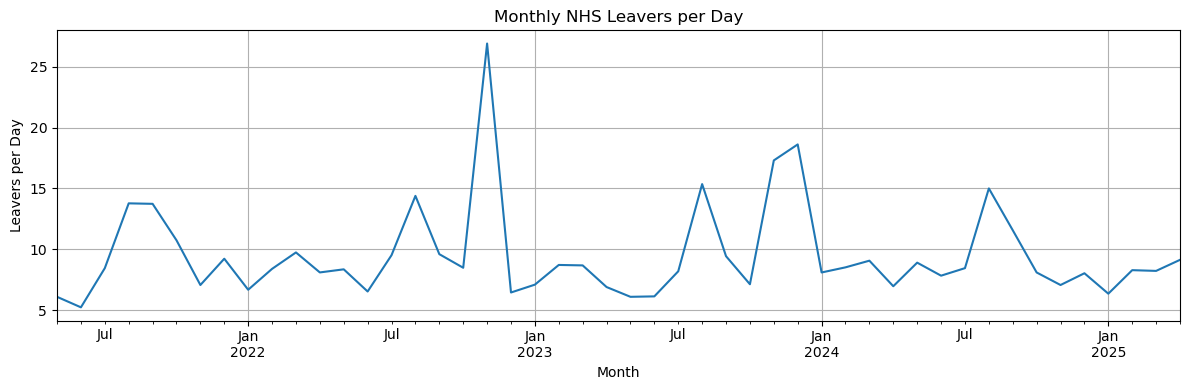

In [40]:
plt.figure(figsize=(12, 4))
y_train.plot(title='Monthly NHS Leavers per Day')
plt.ylabel('Leavers per Day')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation 
Early months (2021-2022) - Leavers ranged from ~ 150 - 430 per month
Recent months (2024-2025) - Continue at high levels, peaking at 465 in August 2024

Suggestion: Data shows strong mid year peaks - suggesting that this is likely due to contract/academic cycles.

## Import From forecast-tools

In [41]:
from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score
from forecast_tools.baseline import SNaive
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.model_selection import (rolling_forecast_origin,
                                            cross_validation_score)


## Helper Functions

In [42]:
def arima_preds_to_dataframe(y_train, preds, intervals):
    pred_idx = pd.date_range(start=y_train.index[-1], periods=len(preds)+1, freq=y_train.index.freq)[1:]
    preds_df = pd.DataFrame(preds, index=pred_idx, columns=['mean'])
    intervals_df = pd.DataFrame(intervals, index=pred_idx, columns=['lower', 'upper'])
    
    return preds_df, intervals_df

## Model 1: Default auto_arima

In [43]:
model_1 = auto_arima(y_train, m=12, supress_warnings=True)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   48
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                -131.625
Date:                    Wed, 18 Jun 2025   AIC                            269.250
Time:                            13:36:19   BIC                            274.863
Sample:                        05-01-2021   HQIC                           271.371
                             - 04-01-2025                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.4255      1.131      8.336      0.000       7.209      11.642
ma.S.L12       0.2834      0.189      1.498      0.134      -0.087       0.654
sigma2        13.8123      2.012      6.866      0.000       9.869      17.755
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               256.77
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.77
Prob(H) (two-sided):                  0.46   Kurtosis:                        12.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model 2: Force first differencing 

In [44]:
model_2 = auto_arima(y_train, m=12, suppress_warnings=True)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   48
Model:             SARIMAX(0, 0, [1], 12)   Log Likelihood                -131.625
Date:                    Wed, 18 Jun 2025   AIC                            269.250
Time:                            13:36:22   BIC                            274.863
Sample:                        05-01-2021   HQIC                           271.371
                             - 04-01-2025                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.4255      1.131      8.336      0.000       7.209      11.642
ma.S.L12       0.2834      0.189      1.498      0.134      -0.087       0.654
sigma2        13.8123      2.012      6.866      0.000       9.869      17.755
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               256.77
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             2.77
Prob(H) (two-sided):                  0.46   Kurtosis:                        12.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model 3: Manually chosen ARIMA(3,1,0)(1,0,0)[12]

In [45]:
model_3 = ARIMA(order=(3, 1, 0), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
model_3.fit(y_train)
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(3, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -134.778
Date:                            Wed, 18 Jun 2025   AIC                            281.556
Time:                                    13:36:23   BIC                            292.657
Sample:                                05-01-2021   HQIC                           285.734
                                     - 04-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0753      0.962      0.078      0.938      -1.810       1.960
ar.L1         -0.6243      0.145     -4.315      0.000      -0.908      -0.341
ar.L2         -0.5209      0.195     -2.664      0.008      -0.904      -0.138
ar.L3         -0.1715      0.200     -0.856      0.392      -0.564       0.221
ar.S.L12       0.1843      0.147      1.258      0.208      -0.103       0.472
sigma2        17.7203      3.639      4.869      0.000      10.587      24.853
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                43.05
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             1.24
Prob(H) (two-sided):                  0.95   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Cross Validation

In [48]:
cv = RollingForecastCV(h=6, step=1, initial=len(y_train) // 3)

score1 = cross_val_score(model_1, y_train, cv=cv, scoring='mean_absolute_error').mean()
score2 = cross_val_score(model_2, y_train, cv=cv, scoring='mean_absolute_error').mean()
score3 = cross_val_score(model_3, y_train, cv=cv, scoring='mean_absolute_error').mean()

print("Cross Validation MAE:")
print(f"Model 1: {score1:.2f}")
print(f"Model 2: {score2:.2f}")
print(f"Model 3: {score3:.2f}")

Cross Validation MAE:
Model 1: 2.73
Model 2: 2.73
Model 3: 4.79


## Model Interpretation 

Best Model: Model 1
- Lowest Akaike information criterion (AIC) (Lower AIC indicates the model losses less information (a better fit))
- Lowest mean absolute error (MAE) (lower MAE indicates model predictions match with the actual data)
- NOTE: 'abnormal' residuals and a heavy skew + kurtosis indicate violations of assumptions - meaning further residual diagnostics is required

Model 3
- Slightly better fit to training data HOWEVER worse generalisation due to higher cross-validation MAE - 4.79
- Most likely overfitting due to added complexity

## Forecasting (24-month horizon)

In [49]:
HORIZON = 24

preds1, ints1 = model_1.predict(n_preiods=HORIZON, return_conf_int=True)
preds2, ints2 = model_2.predict(n_preiods=HORIZON, return_conf_int=True)
preds3, ints3 = model_3.predict(n_preiods=HORIZON, return_conf_int=True)

In [50]:
preds1_df, ints1_df = arima_preds_to_dataframe(y_train, preds1, ints1)
preds2_df, ints2_df = arima_preds_to_dataframe(y_train, preds2, ints2)
preds3_df, ints3_df = arima_preds_to_dataframe(y_train, preds3, ints3)

## Plotted Forecast 

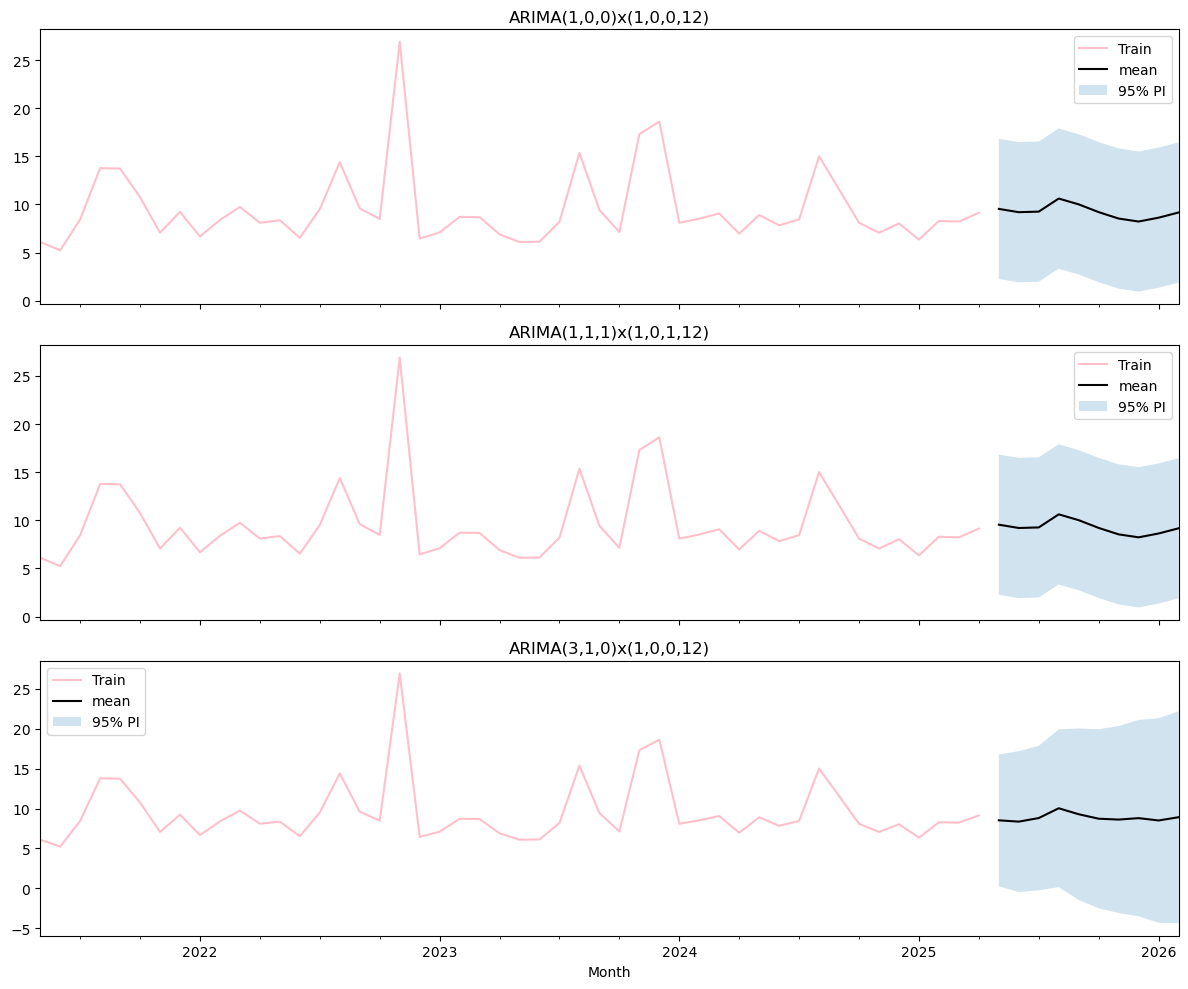

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for i, (train, forecast, interval, label) in enumerate([
    (y_train, preds1_df, ints1_df, 'ARIMA(1,0,0)x(1,0,0,12)'),
    (y_train, preds2_df, ints2_df, 'ARIMA(1,1,1)x(1,0,1,12)'),
    (y_train, preds3_df, ints3_df, 'ARIMA(3,1,0)x(1,0,0,12)')
]):
    train.plot(ax=ax[i], label='Train', color='pink')
    forecast.plot(ax=ax[i], label='Forecast', color='black')
    ax[i].fill_between(interval.index, interval['lower'], interval['upper'],
                       alpha=0.2, label='95% PI')
    ax[i].set_title(label)
    ax[i].legend()

plt.tight_layout()
plt.show()
                    